In [1]:
import numpy as np
import matplotlib.pyplot as plt

A simple inverse problem is

$$Ku(x) = \int_0^x u(y) \mathrm{d}y = \int_0^1 H(x-y)\mathrm{d}y,$$

where $H$ is the Heaviside step function. We can easily verify that the solution to $f(x) = Ku(x)$ is given by $u(x) = f'(x)$.

Upon discretisation with stepsize $h = 1/n$, the inverse problem can be cast as a system of $n$ equations in $n$ unknowns

$$Ku = f.$$

You can use the code provided below to generate the matrix and noisy data for a given $u(x)$.

1. Compute the SVD of $K$ (using `np.linalg.svd`) and plot the singular values and vectors. What do they look like?

2. Plot the coefficients $\langle u_i, f\rangle$ and the singular values $\sigma_i$ to check the discrete Picard condition. What do you notice ?

3. Solve the inverse problem for noisy data using the (regularised) pseudo-inverse; compute the optimal $\alpha$ by computing the bias and variance components of the error. How does the optimal $\alpha$ depend on the noise level? Is this a practically feasible way to compute the optimal $\alpha$?

4. Compare the solutions for $\alpha < \alpha_{opt}$ and $\alpha > \alpha_{opt}$ to the ground truth. What do you notice?

In [2]:
def getK(n):
    h = 1/n;
    x = np.linspace(h/2,1-h/2,n)
    xx,yy = np.meshgrid(x,x)
    K = np.heaviside(xx-yy,1)
    
    return K,x

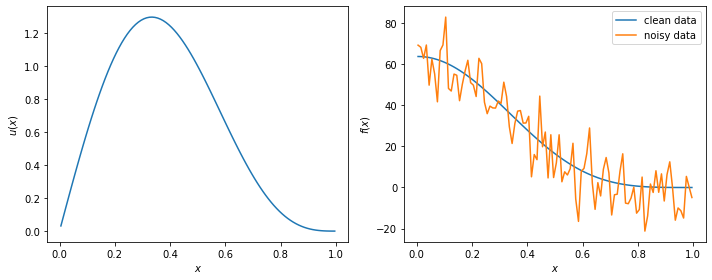

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# define forward operator
n = 100
delta = 1e1
K,x = getK(n)

# define ground truth and compute data
u = np.sin(np.pi*x) + 0.5*np.sin(2*np.pi*x)
f = K@u

# add noise
noise = np.random.randn(n)
f_delta = f + delta*noise

# plot ground truth and data
fig, axs = plt.subplots(1,2)

axs[0].plot(x,u)
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$u(x)$')

axs[1].plot(x,f,label='clean data')
axs[1].plot(x,f_delta,label='noisy data')

axs[1].set_xlabel(r'$x$')
axs[1].set_ylabel(r'$f(x)$')
axs[1].legend()

fig.set_figwidth(10)
fig.tight_layout()
plt.show()

# 1

First, we compute the SVD and plot the singular values and vectors. We note that the singular values decay, but not very rapidly. The singular vectors are basically sinusoids whose frequency is inversly proportional to the magnintude of the singular values. 

In [40]:
# SVD
U, s, Vh = np.linalg.svd(K, full_matrices=True)

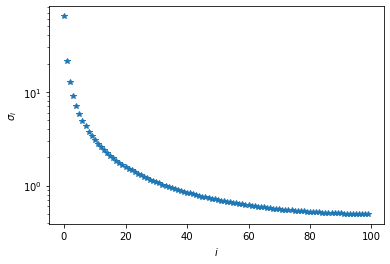

In [41]:
plt.semilogy(s,'*')
plt.xlabel(r'$i$')
plt.ylabel(r'$\sigma_i$')

plt.show()

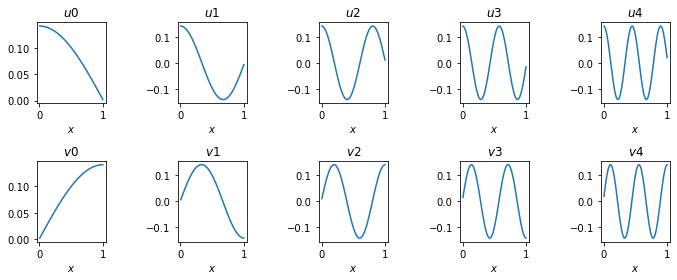

In [71]:
fig, ax = plt.subplots(2,5)

for i in range(5):
    ax[0,i].plot(x,U[:,i])
    ax[0,i].set_title(r'$u$'+str(i))
    ax[0,i].set_xlabel(r'$x$')
    ax[1,i].plot(x,Vh[i,:])
    ax[1,i].set_title(r'$v$'+str(i))
    ax[1,i].set_xlabel(r'$x$')
fig.tight_layout()
fig.set_figwidth(10)

# 2
Plotting the Fourier coefficients $|\langle u_i, f\rangle|$ and $|\langle u_i, f^\delta\rangle|$ along with the singular values, we note that the Fourier coefficients for the noiseless data decay faster than the singular values (hence, they obey the Picard condition). For the noisy data, however, we see that they fail to decay faster and hence we can expect blowup of modes corresponding to small Fourier coefficients. In this case, using the insight from the previous exercise, we see that these are high frequencies in the data.

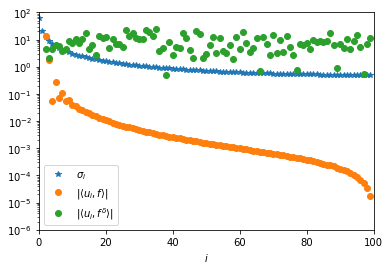

In [43]:
# plot coefficients
fig, ax = plt.subplots(1,1)

ax.semilogy(s,'*',label=r'$\sigma_i$')
ax.semilogy(np.abs(U.T@f),'o',label=r'$|\langle u_i, f\rangle|$')
ax.semilogy(np.abs(U.T@f_delta),'o',label=r'$|\langle u_i, f^{\delta}\rangle|$')
ax.set_xlabel(r'$i$')
ax.set_ylim([1e-6,1e2])
ax.set_xlim([0,n])
ax.legend()

# 3
Plotting the bias and variance terms, as well as the total error $\|K^\delta f - K^\dagger_\alpha f^\delta\|$ as a function of $\alpha$, we notice a clear optimum. If we vary the noise level, should get a table that looks roughly like this:

| $\delta$ | $\alpha$ | 
|----------|----------|
| 0.001    |   0.1    |
| 0.01     |   2.1    | 
| 0.1      |   6.2    |
| 1        |   28     |
| 10       |   122    |

Theoretically we expect that $\alpha \sim \delta^{2}$ (we won't explain why), and this seems plausible here.


In [44]:
# define regularised solutions for f and f_delta
u_clean = lambda alpha : Vh.T@np.diag(s/(s**2 + alpha))@U.T@f
u_noise = lambda alpha : Vh.T@np.diag(s/(s**2 + alpha))@U.T@f_delta

# bias, variance and total error
bias = lambda alpha : np.linalg.norm(u_clean(0) - u_clean(alpha))
variance = lambda alpha : np.linalg.norm(u_clean(alpha) - u_noise(alpha))
total = lambda alpha : np.linalg.norm(u_clean(0) - u_noise(alpha))

delta         =  10.0
optimal alpha =  113.28979591836735


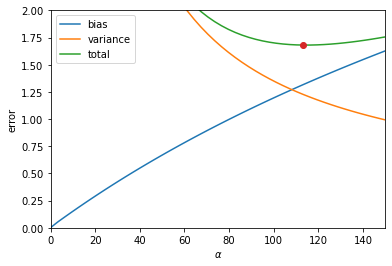

In [69]:
# plot
na = 50
alpha = np.linspace(.1,150,na)
error_b = np.zeros(na)
error_v = np.zeros(na)
error_t = np.zeros(na)

for i in range(na):
  error_b[i] = bias(alpha[i])
  error_v[i] = variance(alpha[i])
  error_t[i] = total(alpha[i])

alpha_opt = alpha[np.argmin(error_t)]

print('delta         = ', delta)
print('optimal alpha = ', alpha_opt)

plt.plot(alpha,error_b,label='bias')
plt.plot(alpha,error_v,label='variance')
plt.plot(alpha,error_t,label='total')
plt.plot(alpha_opt, error_t[np.argmin(error_t)],'o')
plt.xlim([0,150])
plt.ylim([0,2])
plt.xlabel(r'$\alpha$')
plt.ylabel('error')
plt.legend()

# 4
We consistently see that underregularisation leads to a noisy solution while overregularisation leads to a solution that is to smooth and has a lower amplitude.

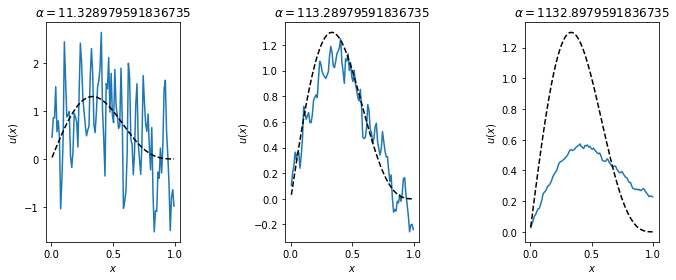

In [70]:
# plot solution for range of alpha's
alphas = [1e-1*alpha_opt, alpha_opt, 1e1*alpha_opt]
nas = len(alphas)
fig, ax = plt.subplots(1,nas)
for i in range(nas):
    ax[i].plot(x,u_noise(alphas[i]))
    ax[i].plot(x,u,'k--')
    ax[i].set_title(r'$\alpha=$'+str(alphas[i]))
    ax[i].set_xlabel(r'$x$')
    ax[i].set_ylabel(r'$u(x)$')
    
fig.tight_layout()
fig.set_figwidth(10)